### Investigate the influence of hyper parameters

goals:
- study the influence
- justify why this is happening
- find best parameters

investigated parameters (we build the list as we go)

- pb_c_base (in progress) so far lowering to 500 led to better results 

In [4]:
import numpy as np
from plot import plot_result_csv, plot_result_event

### $c_1$ and $c_2$ (pb_c_init and pb_c_base)
$$
a^k=\arg \max _a \Big[Q(s,a)+P(s,a) \cdot \frac{\sqrt{\sum_b N(s,b)}}{1+N(s,a)}(c_1+\log{\frac{\sum_bN(s,b)+c_2+1}{c_2}})\Big]
$$
$a$ denotes action, $Q$ denotes value, $P$ denotes policy, $N$ denotes visit counts. $b$ in $N(s,b)$ denotes all the actions from node(state) $s$, and $N(s,b)$ denotes the visit count of the node after conducting action $b$ from $s$. Each MCTS will backpropagate to the root node and all the node visited will add one visit count. Thus, $\frac{N(s,a)}{\sqrt{\sum_b N(s,b)}}$ shows the priority of the action $a$ from all the actions and its reciprocal shows the exploration. Note that if prediction network works well, which shows that $P(s,a)$ is like MCTS,  $P(s,a)$ will reduce the influence of the $\frac{\sqrt{\sum_b N(s,b)}}{1+N(s,a)}$. So we can conclude that the first term means *greedy strategy* and the secend term means *exploration*.  
Increasing $c_1$ will increase exploration obviously. As for $c_2$, descreasing $c_2$ will increase exploration but the exploration is affected by the maximum visit count in MCTS according to 
$$
\log{\frac{\sum_bN(s,b)+c_2+1}{c_2}}=\log{(\frac{\sum_bN(s,b)+1}{c_2}+1)}
$$
Note the maximum of $\sum_bN(s,b)$ is num_simulations (=50) if the laser does not pass the same pixel repeatedly.


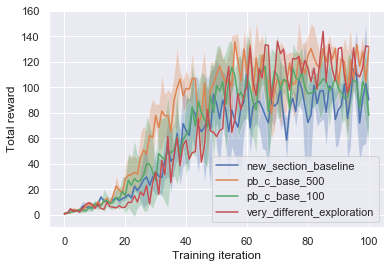

In [5]:
folders = ['new_section_baseline', 'pb_c_base_500','pb_c_base_100','very_different_exploration']
filenames = ['Total reward']
files = [[['Tensorboard_data/{}/1/{}.csv'.format(folder, filename),
         'Tensorboard_data/{}/2/{}.csv'.format(folder, filename),
         'Tensorboard_data/{}/3/{}.csv'.format(folder, filename),]
        for filename in filenames] for folder in folders]

plot_result_csv(folders, filenames, files, max_length = 800, ifsave = False)

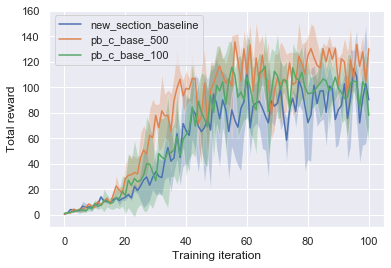

In [6]:
folders = ['new_section_baseline', 'pb_c_base_500','pb_c_base_100']
filenames = ['1.Reward/1.Total reward']
labels = ['Total reward']
files = [['Tensorboard_data/{}/1'.format(folder),
         'Tensorboard_data/{}/2'.format(folder),
         'Tensorboard_data/{}/3'.format(folder),]
        for folder in folders]

plot_result_event(folders, filenames, files, max_length = 800, ifsave = False, labels = labels)

### Temperature_threshold
In Atari game, actions are selected from visit count distribution throughout the duration of the game. For Go, actions are selected from the visit count distribution before Temperature_threshold moves. And when the number of moves reach Temperature_threshold, temperature will be set to 0.

### Dirichlet distribution: 
#### root_dirichlet_alpha
This is pdf (probability density function) of Dirichlet distribution:
$$
f(x_1,...,x_k;a_1,...,a_k)=\frac{1}{B(a)}\prod_{i=1}^{k}x_i^{a_i-1}
$$
where $\sum _{i=1}^kx_i=1$, and $\forall x_i>0$.  
Note that we do not need to care about $B(a)$.  
And it is obvious that when $\forall a<1$, the $x$ will be more likely at the boundary. And $x$ near the boundary means exploration.  
If $a = 1$, there is no exploration noise.
#### root_exploration_fraction
This is exploration noise fraction

In [7]:
# test dirichlet distribution
n=400
a=0.25 # test 1
d=0.9
sumd=0

# count the probability of s containing one element bigger than d=0.9, 
# which means near the boundary. sum(s)=1
for _ in range(n):
    s = np.random.dirichlet(np.asarray([a,a,a]))
    if (s>np.asarray([d,d,d])).any():
        sumd+=1
    
print(sumd/n)

0.375


### num_unroll_steps
When getting batches from game_history, firstly sample the games and then sample the game position. num_unroll_steps means getting num_unroll_steps history for certain game position in certain game.

### td_steps
td_steps means the number of steps used to calculate the target value and target reward.

#### temperature
$T$
$$
p_a=\frac{N(s,a)^{\frac{1}{T}}}{\sum_bN(s,b)^{\frac{1}{T}}}
$$
where $p_a$ is the probability of choosing action $a$. $T = 1$ means probability is proportional to the visit count. $T<1$ means the bigger visit count means bigger probability compared with the proportion. $T=0$ means choosing the maximum one.